In [93]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [94]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: CPU")

GPU unavailable: CPU


In [95]:
class Sales:
    def __init__(self, all_offer_sets, sell_num, mask):
        self.offer_set_list = []
        self.fw = None
        self.N_sales = torch.tensor(np.concatenate(sell_num, axis=1), dtype=torch.float64, device=device)
        self.offer_feature = torch.tensor(all_offer_sets, dtype=torch.float64)
        self.original_shape = self.offer_feature.shape
        self.feature_concat = self.offer_feature.reshape(-1, self.offer_feature.shape[2]).to(device)
        self.N = len(all_offer_sets)
        self.mask = torch.tensor(mask, dtype=torch.float64, device=device)
        self.mask_flat = self.mask.reshape((-1,))
        self.masked_feature_concat = self.feature_concat[self.mask_flat == 1]

    def calculate_all_choice_prob(self, W):
        rule_feature = self.feature_concat
        self.fw = self.calculate_choice_prob(rule_feature, W)
        return self.fw

    def calculate_choice_prob(self, rule_feature, W):
        Z = torch.matmul(rule_feature, W).reshape(self.original_shape[:2])
        masked_Z = Z.masked_fill(self.mask == 0, float('-inf'))
        softmax_result = F.softmax(masked_Z, dim=-1).reshape((-1, 1))[self.mask_flat == 1]
        return softmax_result

In [96]:
class Problem_MNL:
    def __init__(self, S, N, M):
        self.W = None
        self.sales = Sales(S, N, M)
        # Define and initialize the ruleset
        self.feature_num = S.shape[-1]
        # Put the feature to the GPU
        self.sales.feature_concat = self.sales.feature_concat.to(device)
        # Define a consumer list that contain consumer types
        self.consumer_list = []
        # Define the main problem NLL loss
        self.NLL_main = None
        # Define the current likelihood convex combination
        self.g = None
        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None
        # Define a list to contain all fw choice likelihood
        self.fw_list = []
        # Define a new sales data for further estimation
        self.sales_estimate = None

    def loss(self, W):
        N = self.sales.N
        N_sales = self.sales.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = self.sales.calculate_all_choice_prob(W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

    def optimize_w(self):
        W = torch.zeros(self.feature_num, 1, dtype=torch.float64, requires_grad=True, device=device)
        loss_previous = 1e10000
        optimizer = optim.Adam([W], lr=5e-6)
        optimizer.zero_grad()
        NLL_list = []
        w_previous = None
        epoches = 10000
        for epoch in range(epoches):
            LOSS = self.loss(W)
            LOSS.backward()
            optimizer.step()
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epoches}], Loss: {LOSS.item():.4f}')
            loss_current = LOSS.item()
            if loss_current < loss_previous:
                loss_previous = loss_current
                with torch.no_grad():
                    w_previous = W
            else:
                W = w_previous.requires_grad_(True)
                break
            NLL_list.append(loss_current)
        self.W = W
        return NLL_list

    def estimate(self, S, N, M):
        sales_estimate = Sales(S, N, M)
        N = sales_estimate.N
        N_sales = sales_estimate.N_sales
        normalize_term = torch.tensor(1 / N, dtype=torch.float64, device=device)
        fw = sales_estimate.calculate_all_choice_prob(self.W)
        fw_log = torch.log(fw)
        return -normalize_term * torch.matmul(N_sales, fw_log)

In [97]:
def get_offer_data(data_para):
    offerset_list = []
    sell_list = []
    mask_list = []
    max_num = 33
    for srch_id, group in data_para:
        num_product = len(group)
        offerset = group.drop(columns=['booking_bool', 'srch_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy))
        offer_mask = np.append(np.ones(num_product + 1), np.zeros(max_num - num_product - 1))

        if group['booking_bool'].sum() == 0:
            num_sell = np.append(group['booking_bool'].values, 1).reshape(1, -1)
        else:
            num_sell = np.append(group['booking_bool'].values, 0).reshape(1, -1)

        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)
    return offerset_list, sell_list, mask_list


search_info = ['srch_id']
feature = ['position', 'prop_starrating',
           'prop_location_score1', 'prop_log_historical_price',
           'prop_brand_bool', 'promotion_flag', 'srch_booking_window', 'srch_length_of_stay',
           'srch_adults_count', 'srch_children_count', 'srch_room_count',
           'srch_saturday_night_bool', 'price_usd', 'random_bool', 'booking_bool']

tr_data = pd.read_csv('/content/drive/MyDrive/Choice Model/train_28-32_10000.csv')
te_data = pd.read_csv('/content/drive/MyDrive/Choice Model/test_28-32_1000.csv')
tr_data = tr_data[search_info + feature]
te_data = te_data[search_info + feature]
tr_offerset_list, tr_sell_list, tr_mask_list = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list = get_offer_data(te_data.groupby('srch_id'))

Epoch [100/10000], Loss: 3.4467
Epoch [200/10000], Loss: 3.4321
Epoch [300/10000], Loss: 3.4201
Epoch [400/10000], Loss: 3.4103
Epoch [500/10000], Loss: 3.4023
Epoch [600/10000], Loss: 3.3955
Epoch [700/10000], Loss: 3.3892
Epoch [800/10000], Loss: 3.3828
Epoch [900/10000], Loss: 3.3757
Epoch [1000/10000], Loss: 3.3672
Epoch [1100/10000], Loss: 3.3577
Epoch [1200/10000], Loss: 3.3480
Epoch [1300/10000], Loss: 3.3394
Epoch [1400/10000], Loss: 3.3325
Epoch [1500/10000], Loss: 3.3274
Epoch [1600/10000], Loss: 3.3231
Epoch [1700/10000], Loss: 3.3186
Epoch [1800/10000], Loss: 3.3127
Epoch [1900/10000], Loss: 3.3050
Epoch [2000/10000], Loss: 3.2963
Epoch [2100/10000], Loss: 3.2881
Epoch [2200/10000], Loss: 3.2816
Epoch [2300/10000], Loss: 3.2768
Epoch [2400/10000], Loss: 3.2731
Epoch [2500/10000], Loss: 3.2697
Epoch [2600/10000], Loss: 3.2655
Epoch [2700/10000], Loss: 3.2600
Epoch [2800/10000], Loss: 3.2531
Epoch [2900/10000], Loss: 3.2454
Epoch [3000/10000], Loss: 3.2383
Epoch [3100/10000],

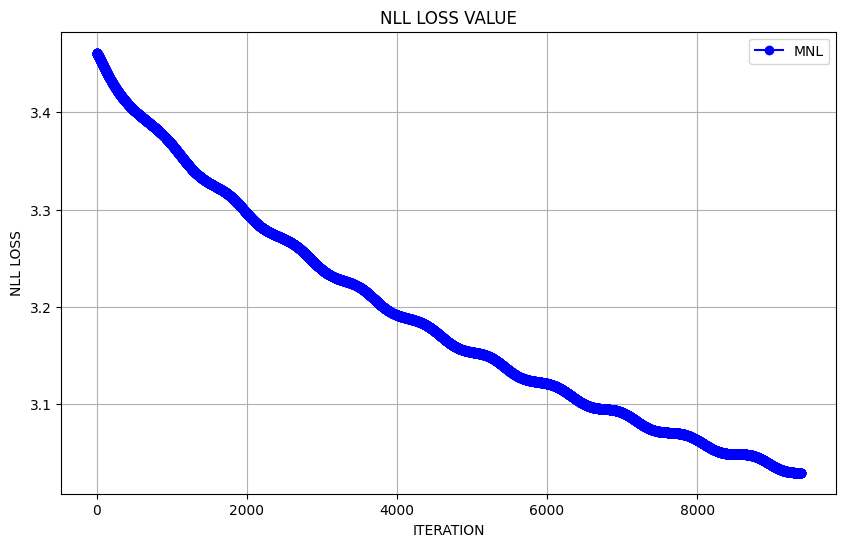

In [98]:
def train_MNL():
    problem = Problem_MNL(tr_offerset_list, tr_sell_list, tr_mask_list)
    NLL_list = problem.optimize_w()
    return problem, NLL_list


MNL_problem, NLL_LIST = train_MNL()
plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST, marker='o', linestyle='-', color='b', label='MNL')
plt.title('NLL LOSS VALUE')
plt.xlabel('ITERATION')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
print('Test Loss: ', MNL_problem.estimate(te_offerset_list, te_sell_list, te_mask_list))
print('Train Loss: ', MNL_problem.estimate(tr_offerset_list, tr_sell_list, tr_mask_list))

Test Loss:  tensor([[3.0333]], dtype=torch.float64, grad_fn=<MulBackward0>)
Train Loss:  tensor([[3.0290]], dtype=torch.float64, grad_fn=<MulBackward0>)
